In [1]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
from vosk import Model
from Signal_Analysis.features.signal import get_HNR
from scipy import signal
from audiostretchy.stretch import stretch_audio


# tools work in progress
import tools

reload(tools)

plt.style.use("dark_background")
mpl.rcParams["lines.linewidth"] = 0.5
plt.close("all")

In [2]:
import os
from librosa import load

examples_dir = "example_speech_mp3/svenska"
filenames = os.listdir(examples_dir)
print(filenames)
audios = []
for f in filenames:
    y, Fs = load(os.path.join(examples_dir, f), sr=None)
    audios.append(y)

wavfile.write("wav_examples/svenska_combo.wav", Fs, tools.stitch_frames(audios))

['common_voice_sv-SE_38528961.mp3', 'common_voice_sv-SE_38528962.mp3', 'common_voice_sv-SE_38528964.mp3', 'common_voice_sv-SE_38528967.mp3', 'common_voice_sv-SE_38528968.mp3', 'common_voice_sv-SE_38543999.mp3', 'common_voice_sv-SE_38544000.mp3', 'common_voice_sv-SE_38544001.mp3', 'common_voice_sv-SE_38544002.mp3', 'common_voice_sv-SE_38544004.mp3', 'common_voice_sv-SE_38544013.mp3', 'common_voice_sv-SE_38544014.mp3', 'common_voice_sv-SE_38544015.mp3', 'common_voice_sv-SE_38544016.mp3', 'common_voice_sv-SE_38544017.mp3', 'common_voice_sv-SE_38568655.mp3', 'common_voice_sv-SE_38568656.mp3', 'common_voice_sv-SE_38568657.mp3', 'common_voice_sv-SE_38568658.mp3', 'common_voice_sv-SE_38568659.mp3', 'common_voice_sv-SE_38568660.mp3', 'common_voice_sv-SE_38568661.mp3', 'common_voice_sv-SE_38568662.mp3', 'common_voice_sv-SE_38568663.mp3', 'common_voice_sv-SE_38568664.mp3', 'common_voice_sv-SE_38568670.mp3', 'common_voice_sv-SE_38568671.mp3', 'common_voice_sv-SE_38568672.mp3', 'common_voice_sv-SE

## preprocess

In [3]:
audio_original_path = "wav_examples/svenska_combo.wav"
_ = tools.preprocess(audio_original_path)

preprocessing svenska_combo


## Speech recognition

In [4]:
audio_path = "audio_preproc/svenska_combo_pp.wav"
Fs, audio = wavfile.read(audio_path)
model_path = "models/vosk-model-small-sv-rhasspy-0.15/"
if "model" not in locals():
    model = Model(model_path)

0 åter ---------------- from 0.42 to 0.87 sec, confidence: 69.39%
1 förvillande --------- from 0.87 to 1.23 sec, confidence: 54.15%
2 vildanden ----------- from 1.23 to 1.53 sec, confidence: 45.85%
3 av ------------------ from 1.56 to 1.68 sec, confidence: 70.28%
4 borås --------------- from 1.68 to 2.19 sec, confidence: 100.00%
5 låg ----------------- from 2.19 to 2.40 sec, confidence: 58.11%
6 högst --------------- from 2.43 to 2.85 sec, confidence: 100.00%
7 på ------------------ from 2.85 to 2.97 sec, confidence: 71.91%
8 agenda -------------- from 2.97 to 3.60 sec, confidence: 71.91%
9 utredaren ----------- from 4.38 to 5.07 sec, confidence: 82.39%
10 ska ----------------- from 5.07 to 5.22 sec, confidence: 100.00%
11 vidare -------------- from 5.22 to 5.61 sec, confidence: 100.00%
12 inhämta ------------- from 5.61 to 6.15 sec, confidence: 100.00%
13 synpunkter ---------- from 6.15 to 6.81 sec, confidence: 100.00%
14 från ---------------- from 6.84 to 7.02 sec, confidence: 100.00

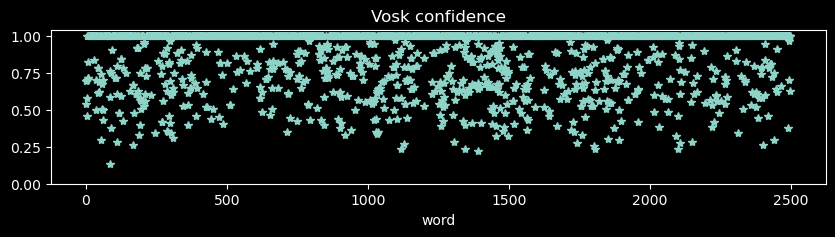

In [5]:
if "words" not in locals():
    words = tools.rec_vosk(audio_path, model, print_summary=True)

text = " ".join([w["word"] for w in words])


print(text)
plt.figure(figsize=(10, 2))
plt.plot([w["conf"] for w in words], "*")
plt.title("Vosk confidence")
plt.xlabel("word")
plt.ylim(bottom=0)
plt.show()

In [6]:
# get all vowels
for w in words:
    w["vowels"] = tools.checkVowels(w["word"], tools.VOWELS_SV)

for i, w in enumerate(words):
    print(i, w["word"], w["vowels"], str(w["conf"] * 100) + "%")

0 åter ['å', 'e'] 69.3943%
1 förvillande ['ö', 'i', 'a', 'e'] 54.1462%
2 vildanden ['i', 'a', 'e'] 45.8538%
3 av ['a'] 70.2828%
4 borås ['o', 'å'] 100.0%
5 låg ['å'] 58.1084%
6 högst ['ö'] 100.0%
7 på ['å'] 71.91149999999999%
8 agenda ['a', 'e', 'a'] 71.91149999999999%
9 utredaren ['u', 'e', 'a', 'e'] 82.3896%
10 ska ['a'] 100.0%
11 vidare ['i', 'a', 'e'] 100.0%
12 inhämta ['i', 'ä', 'a'] 100.0%
13 synpunkter ['y', 'u', 'e'] 100.0%
14 från ['å'] 100.0%
15 berörda ['e', 'ö', 'a'] 100.0%
16 myndigheter ['y', 'i', 'e', 'e'] 100.0%
17 organisationer ['o', 'a', 'i', 'a', 'i', 'o', 'e'] 100.0%
18 och ['o'] 100.0%
19 näringslivsdirektörens ['ä', 'i', 'i', 'i', 'e', 'ö', 'e'] 100.0%
20 jag ['a'] 100.0%
21 har ['a'] 100.0%
22 inte ['i', 'e'] 100.0%
23 läst ['ä'] 100.0%
24 något ['å', 'o'] 100.0%
25 av ['a'] 100.0%
26 honom ['o', 'o'] 100.0%
27 och ['o'] 100.0%
28 känner ['ä', 'e'] 84.1452%
29 honom ['o', 'o'] 100.0%
30 således ['å', 'e', 'e'] 100.0%
31 inte ['i', 'e'] 100.0%
32 vi ['i'] 100.0%


## test 1 word

vildanden
['i', 'a', 'e']
['i', 'a', 'e']
frame length    : 640 samples
frame length    : 0.02 seconds
between frames  : 0.02 seconds
number of frames: 16


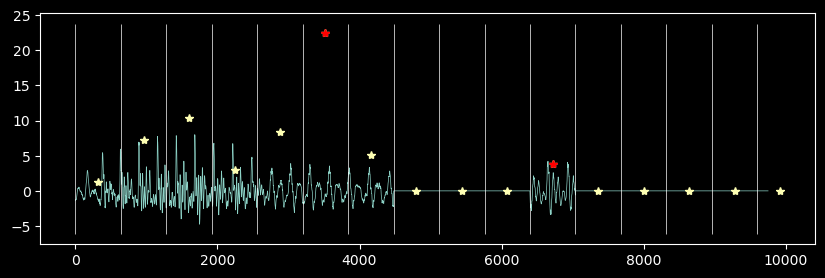

c:\Users\marcu\google_drive\Courses\VowelProject\tools.py:62: RuntimeWarning: invalid value encountered in divide
  return np.int16(x / np.max(np.abs(x)) * np.iinfo(np.int16).max)
c:\Users\marcu\google_drive\Courses\VowelProject\tools.py:62: RuntimeWarning: invalid value encountered in cast
  return np.int16(x / np.max(np.abs(x)) * np.iinfo(np.int16).max)
c:\Users\marcu\google_drive\Courses\VowelProject\tools.py:62: RuntimeWarning: divide by zero encountered in divide
  return np.int16(x / np.max(np.abs(x)) * np.iinfo(np.int16).max)


In [7]:
fl = int(0.02 * Fs)
k = 2
word = words[k]["word"]
print(word)
segments, vowels_per_segment = tools.segment_by_words(words, audio, Fs, tools.VOWELS_SV)
x = segments[k] / segments[k].max()
vowels = vowels_per_segment[k]

print(vowels)
print(words[k]["vowels"])

frames, f_start = tools.split_frames(x, fl, Fs, overlap=0, vol_thr=0.1, print_info=True)

peak_frames, hnr_frames = tools.HNR_short(frames, Fs, len(vowels))

plt.figure(figsize=(10, 3))
plt.plot(8 * np.concatenate(frames))
plt.plot(f_start + int(fl / 2), hnr_frames, "*")
plt.plot(f_start[peak_frames] + int(fl / 2), hnr_frames[peak_frames], "*r")
plt.vlines(f_start, *plt.ylim())

plt.show()

wavfile.write(f"output/1word{word}.wav", Fs, tools.stitch_frames(frames[12:16]))

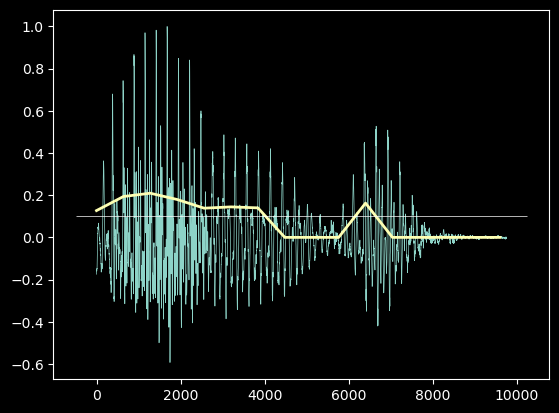

In [8]:
reload(tools)
plt.plot(x)
plt.plot(f_start, [tools.vol(f) for f in frames], linewidth=2)
plt.hlines(0.1, *plt.xlim())
plt.show()

## all words

In [12]:
add_context = False

grouped = {v: [] for v in tools.VOWELS_SV}
segments, vowels_per_segment = tools.segment_by_words(
    words, audio, Fs, tools.VOWELS_SV, signal_pad=0.02
)
for w, segment, vowels in zip(words, segments, vowels_per_segment):
    if w["conf"] >= 1:
        # print(w["word"], w["conf"])
        segment = np.concatenate((np.zeros(fl), segment, np.zeros(fl)))
        frames, f_start = tools.split_frames(segment, fl, Fs, vol_thr=0.1, overlap=0)
        peak_frames, hnr_frames = tools.HNR_short(frames, Fs, len(vowels))
        if len(peak_frames) == len(vowels):
            for i, v in enumerate(vowels):
                if not tools.checkIfWhite(frames[peak_frames[i]]):
                    if add_context:
                        grouped[v].append(
                            tools.stitch_frames(
                                frames[
                                    max(peak_frames[i] - 2, 0) : min(
                                        peak_frames[i] + 2, len(frames)
                                    )
                                ]
                            )
                        )
                    else:
                        grouped[v].append(frames[peak_frames[i]])

audio_out = {}
for v in grouped.keys():
    audio_out[v] = tools.stitch_frames(
        grouped[v], fade_pow=0.7, padding=(Fs / 4) * add_context
    )

    path = f"output/concatenated/concatenated_{v}.wav"
    wavfile.write(path, Fs, audio_out[v])
    # stretch_audio(path, path, 1)

In [13]:
vowels_in_text = {v: 0 for v in tools.VOWELS_SV}
for c in tools.checkVowels(text, tools.VOWELS_SV):
    vowels_in_text[c] += 1

print("found vowels:")
for v in grouped.keys():
    print(
        "    ",
        v,
        len(grouped[v]),
        str(round(100 * len(grouped[v]) / vowels_in_text[v], 3)) + "%",
    )

found vowels:
     ö 136 73.514%
     o 339 69.897%
     ä 158 61.24%
     a 765 69.799%
     y 40 61.538%
     i 368 64.903%
     e 752 64.605%
     u 161 69.397%
     å 173 70.04%


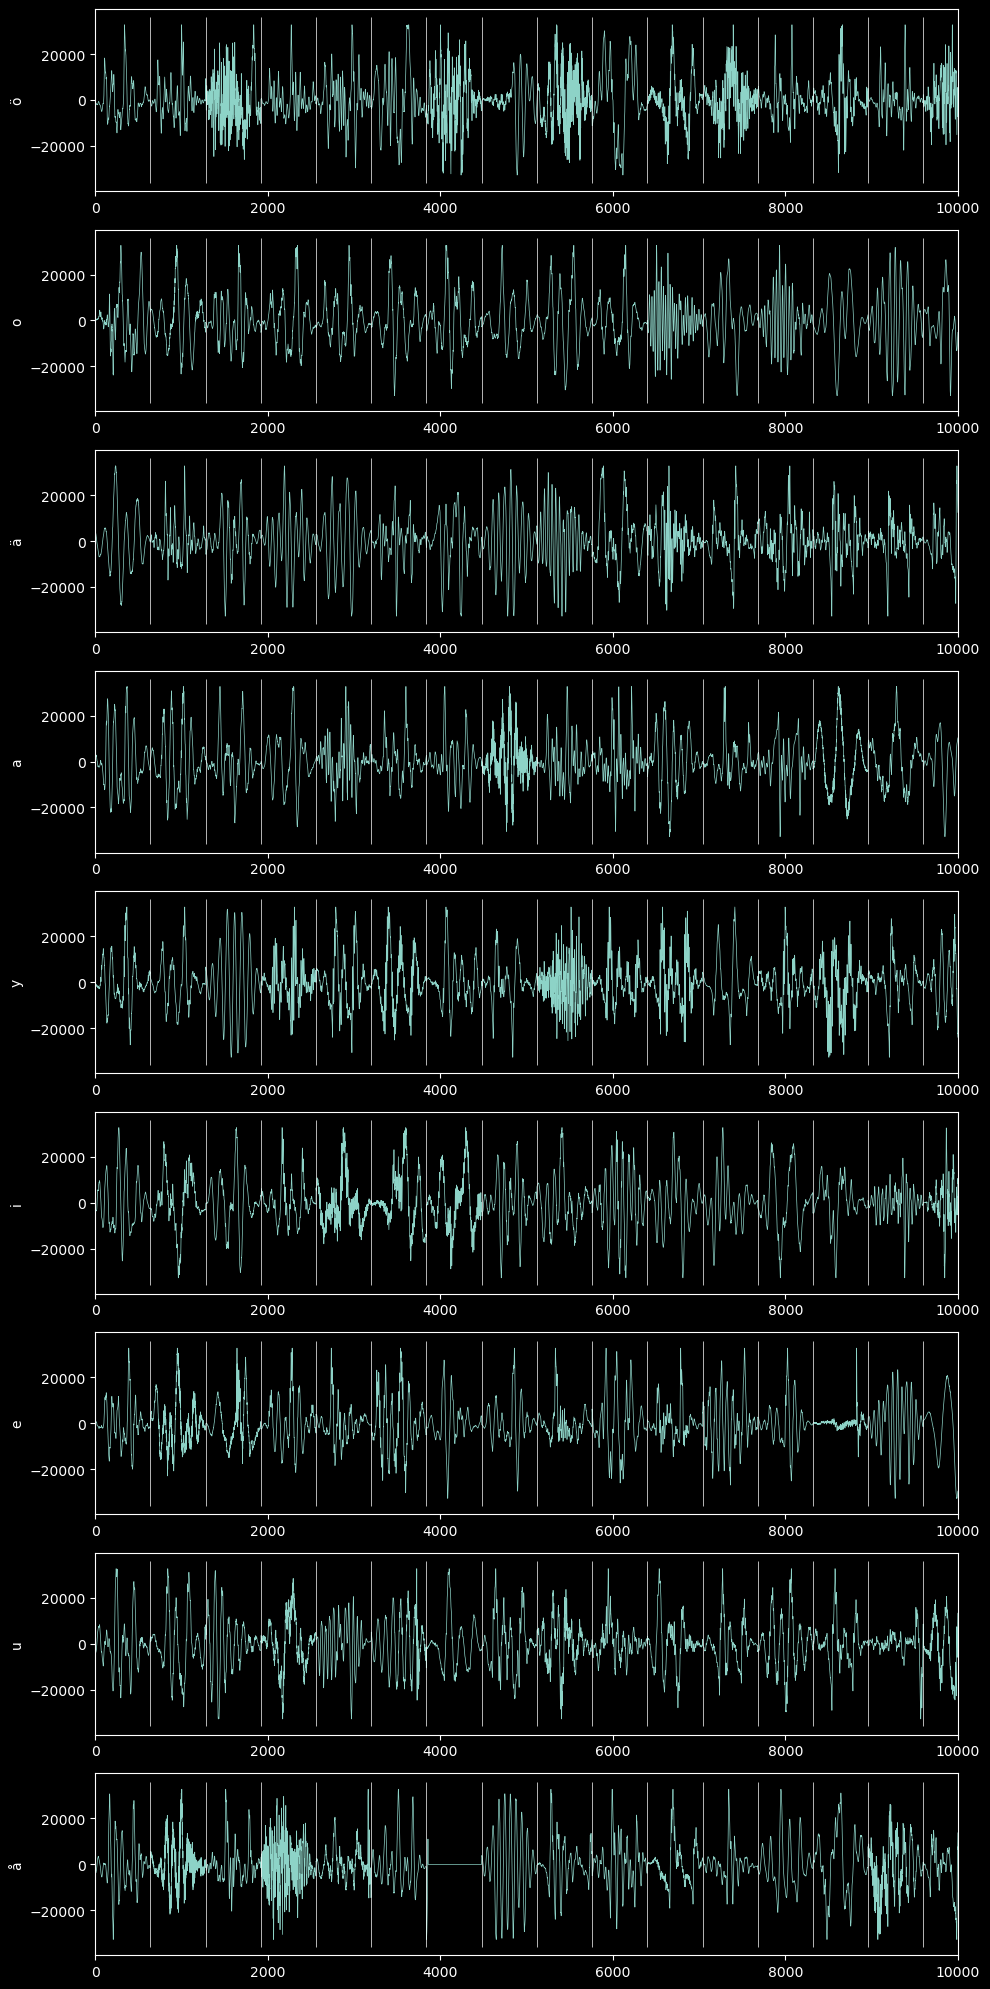

In [16]:
plt.figure(figsize=((10, 20)))
for i, v in enumerate(audio_out.keys()):
    plt.subplot(len(tools.VOWELS_SV), 1, i + 1)
    plt.plot(audio_out[v])
    plt.xlim(0, 10000)
    plt.vlines(np.arange(0, len(audio_out[v]), fl), *plt.ylim())
    plt.ylabel(v)

plt.tight_layout()